In [1]:
import nest_asyncio
nest_asyncio.apply()

import numpy as np
import stan
import matplotlib.pyplot as plt

import arviz as az

In [2]:
model_ddcrp_simplified1 = """
data {
    int N; // Number of data points
    int M; // number of possible observations
    array[N] int Y;
    matrix[N,N] is_same_context_1;
    matrix[N,N] is_same_1_back;

    real prior_alpha_shape;
    real prior_alpha_scale;

    real prior_timeconstant_within_session_shape;
    real prior_timeconstant_within_session_scale;

    real prior_repeat_bias_1_back_shape;
    real prior_repeat_bias_1_back_scale;

    real prior_context_similarity_depth_1_alpha;
    real prior_context_similarity_depth_1_beta;
}
transformed data {
    // variables to turn main computation in matrix operations
    matrix[N,N] is_same_observation;
    matrix[N,N] is_prev_observation;
    matrix[N,N] is_different_context_1;
    matrix[N,N] deltas;
    for (aa in 1:N) {
        for (bb in 1:N) {
            if(bb < aa) {
                deltas[aa,bb] = aa-bb;
                is_prev_observation[aa,bb] = 1;
            }
            else {
                deltas[aa,bb] = 1;
                is_prev_observation[aa,bb] = 0;
            }
            if(bb < aa && Y[aa] == Y[bb]) {
                is_same_observation[aa,bb] = 1;
            }
            else {
                is_same_observation[aa,bb] = 0;
            }
            
            if(bb < aa && is_same_context_1[aa,bb] <= 0) {
                is_different_context_1[aa,bb] = 1;
            }
            else {
                is_different_context_1[aa,bb] = 0;
            }
        }
    }

    vector[N] Y_is_same_as_one_back = rep_vector(0, N);
    for (aa in 2:N) {
        if(Y[aa] == Y[aa-1]) {
            Y_is_same_as_one_back[aa] = 1;
        }
    }
    // vector[N] log_BaseMeasure = rep_vector(-log(M),N) ;
    
    vector[N] vs = rep_vector(1.0,N) ;
    array[N] int vi ;
    for (aa in 1:N) {
        vi[aa] = 1;
    }

    // prior parameter transformations for computations
    real prior_alpha_scale_log = log(prior_alpha_scale);
    real prior_alpha_scale_inv = 1.0/prior_alpha_scale;

    real prior_timeconstant_within_session_scale_log = log(prior_timeconstant_within_session_scale);
    real prior_timeconstant_within_session_scale_inv = 1.0/prior_timeconstant_within_session_scale;

    real prior_repeat_bias_1_back_scale     = 1.0/prior_repeat_bias_1_back_shape;
    real prior_repeat_bias_1_back_scale_inv = prior_repeat_bias_1_back_shape;
    real prior_repeat_bias_1_back_scale_log = log(prior_repeat_bias_1_back_scale);
}
parameters {
    real log_alpha_n;   
    real log_timeconstant_within_session_n;      
    real log_repeat_bias_1_back_n;   
    
    //real logit_context_similarity_depth_1;  
    real<upper=0> log_context_similarity_depth_1;     
}
transformed parameters { 
    real log_alpha;   
    real log_timeconstant_within_session;      
    real log_repeat_bias_1_back; 

    log_alpha                       = log_alpha_n                       + prior_alpha_scale_log;
    log_timeconstant_within_session = log_timeconstant_within_session_n + prior_timeconstant_within_session_scale_log;
    log_repeat_bias_1_back          = log_repeat_bias_1_back_n          + prior_repeat_bias_1_back_scale_log;

    real<lower=0> alpha;
    real<lower=0> timeconstant_within_session;         
    real<lower=0> repeat_bias_1_back;   

    alpha                       = exp(log_alpha);
    timeconstant_within_session = exp(log_timeconstant_within_session); 
    repeat_bias_1_back          = exp(log_repeat_bias_1_back);

    real<lower=0,upper=1> context_similarity_depth_1; 
    //real<upper=0>         log_context_similarity_depth_1;

    //context_similarity_depth_1     = inv_logit(logit_context_similarity_depth_1);
    //log_context_similarity_depth_1 = log(context_similarity_depth_1);
    context_similarity_depth_1     = exp(log_context_similarity_depth_1);
}
model {
    matrix[N,N] weights_same_obs;
    matrix[N,N] weights_all_obs;
    vector[N] ps;
    vector[N] aa;
    vector[N] BaseMeasure;
    // real BaseMeasure;
    
    alpha                       ~ gamma(prior_alpha_shape,                       prior_alpha_scale_inv);
    timeconstant_within_session ~ gamma(prior_timeconstant_within_session_shape, prior_timeconstant_within_session_scale_inv);
    repeat_bias_1_back          ~ gamma(prior_repeat_bias_1_back_shape,          prior_repeat_bias_1_back_scale_inv);

    context_similarity_depth_1  ~ beta(prior_context_similarity_depth_1_alpha,   prior_context_similarity_depth_1_beta);
    
    BaseMeasure = ((repeat_bias_1_back-1.0) * Y_is_same_as_one_back + 1.0) / (repeat_bias_1_back + (M-1.0));
    //BaseMeasure = 1.0/M;

    weights_all_obs   = is_prev_observation .* exp(-deltas/timeconstant_within_session 
                                                   + log_context_similarity_depth_1   * is_different_context_1
                                                   + log_repeat_bias_1_back           * is_same_1_back);
    //weights_all_obs   = is_prev_observation .* exp(-deltas/timeconstant_within_session);
    weights_same_obs  = is_same_observation .* weights_all_obs[:,1:N];

    // probability of drawing the observed observations given their pasts
    ps =  ((weights_same_obs * vs) + (alpha*BaseMeasure)) ./  ((weights_all_obs * vs) + (alpha));

    vi ~ bernoulli(ps); // note: not generative - this is a simplified distribution to make the log likelihood computations work quickly in Stan
}"""

In [3]:
Y = np.random.randint(1,3, size=(50))#np.array([1, 2, 2, 1, 1, 2, 2, 2, 1, ])

N = Y.size
M = 2;

is_same_context_1 = np.zeros((N,N),dtype=int)
is_same_1_back = np.zeros((N,N),dtype=int)
for ii in range(1,N):
    for jj in range(1,ii):
        if(Y[jj-1] == Y[ii-1]):
            is_same_context_1[ii,jj] = 1
        if(Y[jj] == Y[ii-1]):
            is_same_1_back[ii,jj] = 1

In [4]:
data     = {"N" : N, "M" : M, 
            "Y" : Y,
            "is_same_context_1" : is_same_context_1,
            "is_same_1_back"    : is_same_1_back,
            "prior_alpha_shape" : 2.0,
            "prior_alpha_scale" : 5.0,
            "prior_timeconstant_within_session_shape" : 2.0,
            "prior_timeconstant_within_session_scale" : 25.0,
            "prior_repeat_bias_1_back_shape" : 20.0,
            "prior_repeat_bias_1_back_scale" : 1/20.0,
            "prior_context_similarity_depth_1_alpha" : 1.0,
            "prior_context_similarity_depth_1_beta"  : 1.0}
posterior = stan.build(model_ddcrp_simplified1, data=data, random_seed=1)
fit       = posterior.sample(num_chains=4, num_samples=1000)

Building...

In file included from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/prim/fun.hpp:124:0,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/latimerk/.cache/httpstan


Building: 31.0s, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    is provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_alpha_n,0.016,0.824,-1.532,1.527,0.040,0.029,437.0,460.0,1.01
log_timeconstant_within_session_n,-0.634,1.292,-2.961,1.419,0.076,0.054,316.0,362.0,1.01
log_repeat_bias_1_back_n,2.972,0.181,2.623,3.309,0.009,0.006,414.0,593.0,1.01
log_context_similarity_depth_1,-389.721,220.194,-744.584,-36.531,12.523,8.863,315.0,543.0,1.01
log_alpha,1.625,0.824,0.077,3.137,0.040,0.029,437.0,460.0,1.01
log_timeconstant_within_session,2.585,1.292,0.258,4.638,0.076,0.054,316.0,362.0,1.01
log_repeat_bias_1_back,-0.024,0.181,-0.373,0.313,0.009,0.006,414.0,593.0,1.01
alpha,6.850,5.271,0.300,16.402,0.227,0.160,437.0,460.0,1.01
timeconstant_within_session,23.343,22.798,0.013,66.363,1.054,0.746,316.0,362.0,1.01
repeat_bias_1_back,0.992,0.179,0.670,1.346,0.009,0.006,414.0,593.0,1.01


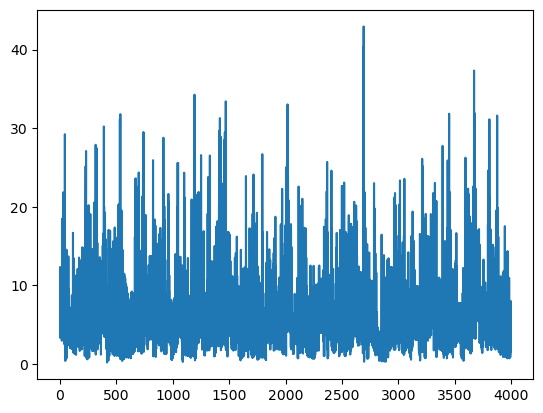

In [8]:
plt.plot(fit["alpha"].flatten())
az.summary(fit)